In [90]:
!pip install skforecast
!pip install statsmodels

     |████████████████████████████████| 9.9 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 75.1 MB/s eta 0:00:01


In [69]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [70]:
water_consumptions = pd.read_csv('./data/water_consumptions_100.csv')
print(water_consumptions.dtypes)
water_consumptions.head()

id              int64
datetime       object
consumption     int64
dtype: object


,id,datetime,consumption
0,0,2019-02-01,243
1,0,2019-02-02,236
2,0,2019-02-03,335
3,0,2019-02-04,252
4,0,2019-02-05,220


In [71]:
water_consumptions['datetime'] = water_consumptions['datetime'].apply(pd.to_datetime)
water_consumptions.dtypes

id                      int64
datetime       datetime64[ns]
consumption             int64
dtype: object

## Data preparation



In [72]:
N_DAYS_YEAR = 365

id_length = water_consumptions.groupby(['id']).size()
print('Number of series:', len(id_length))
complete_series_ids = id_length[id_length == N_DAYS_YEAR]
complete_series_ids = complete_series_ids.to_frame().reset_index()
print('Number of complete series: ', len(complete_series_ids))

Number of series: 101
Number of complete series:  81


In [73]:
complete_series_df = water_consumptions[water_consumptions['id'].isin(complete_series_ids['id'])]
complete_series_df

,id,datetime,consumption
0,0,2019-02-01,243
1,0,2019-02-02,236
2,0,2019-02-03,335
3,0,2019-02-04,252
4,0,2019-02-05,220
...,...,...,...
35589,100,2020-01-27,471
35590,100,2020-01-28,445
35591,100,2020-01-29,720
35592,100,2020-01-30,402


In [74]:
consumption_series = dict()

for id in set(complete_series_df['id']):
  id_df = complete_series_df[complete_series_df['id'] == id]
  date_consumption_df = id_df.loc[:,["datetime","consumption"]]
  date_consumption_df.set_index("datetime",inplace=True)
  date_consumption_df.sort_index(inplace=True)
  consumption_series[id] = date_consumption_df


### Standarization
Once we have the train-test datasets, it's the time to prepare them to improve the performance of the models. In order to do that, we standarize the time series to make the easier to use for the algorithms.
In most cases, it is very important to take care that there is no information leakage between testing and training data. But, in this case, as we want to replicate the clutering from the EDA. We will do, first a complete-dataset-normalization and for train-test we will fit on the training data and then apply the same to the test data

In [75]:
from sklearn.preprocessing import StandardScaler

for index in consumption_series:
    scaler = StandardScaler()
    consumption_series[index] = scaler.fit_transform(consumption_series[index])
    consumption_series[index] = consumption_series[index].reshape(len(consumption_series[index]))
    
water_series_anonimized = list(consumption_series.values())
water_series_anonimized[0]

array([-3.72417048e-01, -4.37922043e-01,  4.88505743e-01, -2.88196340e-01,
       -5.87647745e-01, -6.36077857e-02, -5.42499293e-02, -8.40309869e-01,
       -1.94617776e-01,  3.01348615e-01, -5.50216320e-01,  5.07221456e-01,
       -5.97005602e-01, -1.75902063e-01,  9.47040708e-01, -3.55342164e-02,
        5.63368595e-01,  3.48137897e-01,  1.19034498e+00, -2.22691345e-01,
        2.82632902e-01,  9.18967139e-01, -5.68932033e-01,  6.75662872e-01,
        9.37682852e-01, -3.25627766e-01,  2.91990758e-01, -9.61962002e-01,
       -6.99942023e-01, -4.94069181e-01,  6.66305015e-01,  3.57495753e-01,
        3.38780040e-01,  1.89054338e-01, -3.72417048e-01, -1.38306554e+00,
       -1.57186350e-01,  1.31199711e+00,  2.45365559e+00, -5.87647745e-01,
       -6.90584166e-01,  1.80796350e+00,  3.85569323e-01,  2.99707785e-02,
       -5.40858463e-01, -6.43794884e-01,  1.15291355e+00,  1.12550657e-02,
        9.09609282e-01, -8.77741295e-01,  9.54757735e-02,  9.47040708e-01,
       -5.12784894e-01, -

## Clustering
Once we have the train-test datasets, we have to think about the problem. As we saw in the EDA's stage, the different time series have different behaviours so we decided to cluster them to apply different algorithms or parameters to each cluster.
One thing we have to keep in mind, is that we create the clusters using the train time serie to don't transfer knowledge to the test stage, but in the final predictions for the problem we will use the complete serie.


```Think it```

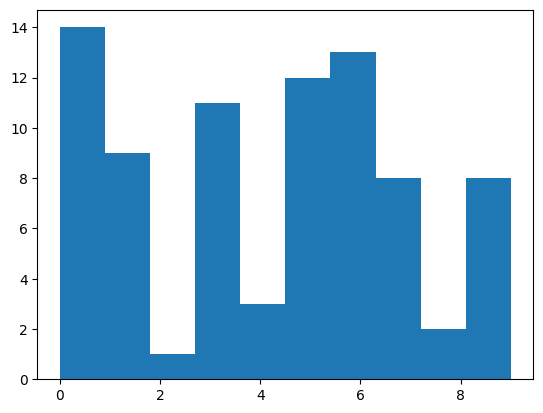

In [76]:
OPTIMAL_NUMBER_CLUSTERS = 10
SEED = 10

k_means = KMeans(n_clusters=OPTIMAL_NUMBER_CLUSTERS, random_state=SEED)
k_means.fit(water_series_anonimized)
cluster_labels = k_means.labels_

y, x, _ = plt.hist(cluster_labels)

In [77]:
id_cluster = dict()
for index in consumption_series:
    predicted = k_means.predict([consumption_series[index]])
    id_cluster[index] = predicted[0]
id_cluster

{0: 6,
 1: 6,
 2: 3,
 3: 7,
 4: 3,
 5: 9,
 6: 1,
 7: 6,
 8: 1,
 9: 9,
 10: 1,
 12: 5,
 13: 0,
 14: 5,
 15: 1,
 16: 0,
 17: 9,
 18: 3,
 19: 5,
 20: 0,
 21: 8,
 22: 7,
 24: 3,
 25: 6,
 27: 3,
 28: 7,
 29: 5,
 30: 3,
 31: 3,
 36: 5,
 38: 0,
 40: 0,
 41: 4,
 42: 5,
 43: 0,
 44: 6,
 45: 6,
 46: 6,
 47: 9,
 48: 3,
 49: 4,
 50: 7,
 51: 1,
 52: 5,
 53: 5,
 55: 9,
 56: 1,
 57: 9,
 58: 2,
 59: 0,
 60: 1,
 61: 6,
 63: 7,
 65: 5,
 66: 0,
 68: 6,
 69: 6,
 70: 1,
 71: 7,
 75: 4,
 77: 6,
 80: 3,
 81: 3,
 82: 0,
 83: 7,
 84: 1,
 86: 5,
 87: 8,
 88: 0,
 89: 0,
 90: 6,
 91: 6,
 92: 9,
 93: 9,
 94: 5,
 95: 0,
 96: 3,
 97: 5,
 98: 0,
 99: 0,
 100: 7}

In [83]:
UNCOMPLETE_SERIE_CLUSTER = 10

def assign_cluster_or_default(id, id_clusters):
  if id in id_clusters.keys():
    return id_clusters[id]
  else:
    return UNCOMPLETE_SERIE_CLUSTER

In [84]:
water_consumptions['cluster'] = water_consumptions.apply(lambda row: assign_cluster_or_default(row.id, id_cluster), axis = 1)
water_consumptions

,id,datetime,consumption,cluster
0,0,2019-02-01,243,6
1,0,2019-02-02,236,6
2,0,2019-02-03,335,6
3,0,2019-02-04,252,6
4,0,2019-02-05,220,6
...,...,...,...,...
35589,100,2020-01-27,471,7
35590,100,2020-01-28,445,7
35591,100,2020-01-29,720,7
35592,100,2020-01-30,402,7


## Training-test datasets
The dataset is a time series. A specific characteristic of a time serie is that in a train-test problem we have to use the first part for training and the second for testing. We can't shuffle the serie to get it balanced or make changes in the order. 
In this problem we picked the first eleven months (2019-02-01 / 2019-12-31), which are the 91% of the dataset, and left the other 9% (2020-01-01 / 2020-01-31) for testing purposes.

In [79]:
print('Datatime range:', min(water_consumptions['datetime']) ,max(water_consumptions['datetime']))

Datatime range: 2019-02-01 00:00:00 2020-01-31 00:00:00


In [85]:
def train_test_split(water_consumptions):
    train =  water_consumptions.loc[water_consumptions['datetime'] < datetime(2020, 1, 1)]
    test = water_consumptions.loc[water_consumptions['datetime'] >= datetime(2020, 1, 1)]
    return train, test

In [86]:
train_df, test_df = train_test_split(water_consumptions)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (32492, 4)
Test shape: (3102, 4)


## Train-Predict by cluster

In [89]:
def generate_append_from_predictions(predicted):
  week_1 = sum(predicted[:7])
  week_2 = sum(predicted[7:])
  days_week_consumptions = np.append(np.append(predicted[:7], week_1), week_2)
  return np.concatenate(([id],days_week_consumptions))
  

def train_predict_by_id(train_dataset, model_per_cluster, params_per_cluster, scaler_per_cluster, default_model, default_params, default_scaler, predict_steps=14):
  column_names = ['id', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'week_1', 'week_2']
  df = pd.DataFrame(columns = column_names)
  ids = set(train_dataset['id'])
  for ts_id in ids:
    try:
      print('id: {id} de {len}, completado: {percent:.2f}%'.format(id=ts_id, len=len(ids), percent=(len(df)/len(ids))*100))
      current_id_time_serie = train_dataset[train_dataset['id'] == ts_id]
      cluster = list(current_id_time_serie['cluster'])[0]
      if cluster < UNCOMPLETE_SERIE_CLUSTER:
        params = params_per_cluster[cluster]
        scaler = scaler_per_cluster[cluster]()
        model = model_per_cluster[cluster](**params, scaler=scaler)
      else:
        scaler = default_scaler()
        model = default_model(**default_params, scaler=scaler)

      model.fit(current_id_time_serie)
      predicted = model.predict(predict_steps)
      to_append = generate_append_from_predictions(predicted)
    except:
      to_append = [ts_id, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    df.loc[len(df)] = to_append
  return df

ModuleNotFoundError: No module named 'statsmodels'